In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
file_id = '1AVbnOfblP2lJTOowA1JFTZ-wS-wYc6b3'
downloaded = drive.CreateFile({'id': file_id})
downloaded = drive.CreateFile({'id':'1AVbnOfblP2lJTOowA1JFTZ-wS-wYc6b3'}) # replace the id with id of file you want to access
downloaded.GetContentFile('cherat-final-dataset.csv')  
 


In [ ]:
# pip --proxy  http://192.41.170.23:3128/ install fbprophet

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
import statsmodels.graphics.tsaplots as sgt
#from sklearn import preprocessing
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
# from pmdarima import auto_arima
from statsmodels.tools.eval_measures import rmse    
from statsmodels.tools.eval_measures import mse   
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from fbprophet import Prophet
from statsmodels.tools.eval_measures import rmse  
from statsmodels.tools.eval_measures import mse  
import warnings 
warnings.filterwarnings ("ignore")


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('cherat-final-dataset.csv')

# Preprocessing #

In [ ]:
def preprocessing(dataframe):
    df = dataframe.iloc[::-1]
    #df = df.drop(['Price', 'High', 'Low'], axis=1)
    df['Date']= pd.to_datetime(df['Date'], format= '%d/%m/%Y')  # datetime conversion.........
    df.set_index("Date", inplace= True) # created date as an index
    return df

In [ ]:
preprocessed_df = preprocessing(df)

In [ ]:
columns_names = ['Net_Margin', 'ROE', 'Quick_Ratio', 'Current_Ratio',
       'Assets_Equity', 'Debt_Equity', 'A_RTurnover', 'AvgA_RDays',
       'InvTurnover', 'EBITDATotAssetsTTM', 'ROATotAssets', 'HistMktCap',
       'HistEV', 'GDPExports', 'Inflationgdp', 'moneysupply',
       'treasures_bill', 'DollarRate_Open']

interpolate_df = []
for i in columns_names:
    a = preprocessed_df[i].interpolate(method='time')
#     plt.scatter(df.index, a,  alpha=0.5, color='red' )
#     plt.scatter(df.index, i,  alpha=0.5, color='blue')
    interpolate_df.append(a)

interpolate_df = pd.DataFrame(interpolate_df).T
df = pd.concat([preprocessed_df.Open, preprocessed_df.Vol,preprocessed_df.High,preprocessed_df.Low,preprocessed_df.Price, interpolate_df], axis = 1)

# Data Normalisation #

In [ ]:
###Standardizing/Normalizing the data
scaler = StandardScaler()
scaler  = scaler.fit(df)
# scaler = StandardScaler.fit(df)
X_scaled = scaler.transform(df)
df_normalise = pd.DataFrame(X_scaled, columns=['Open', 'Vol', 'High', 'Low', 'Price', 'Net_Margin', 'ROE',
       'Quick_Ratio', 'Current_Ratio', 'Assets_Equity', 'Debt_Equity',
       'A_RTurnover', 'AvgA_RDays', 'InvTurnover', 'EBITDATotAssetsTTM',
       'ROATotAssets', 'HistMktCap', 'HistEV', 'GDPExports',
       'Inflationgdp', 'moneysupply', 'treasures_bill', 'DollarRate_Open'])

df_normalise['Date'] = df.index
df_normalise.set_index("Date", inplace= True) 


### Prophet Library function ###

In [ ]:
def prophetlibrary(dataframe):
    prophetdf = pd.DataFrame(dataframe)
    prophetdf.reset_index(level=['Date'],inplace =True)
    prophetdf = prophetdf.rename(columns={'Date': 'ds', 'Open': 'y'})
    prophetdf['ds'] = pd.to_datetime(prophetdf['ds'])  #convert ds to datetime index
    return prophetdf

    

In [ ]:
prophetdf= prophetlibrary(df)

In [ ]:
prophetdf

,ds,y,Vol,High,Low,Price,Net_Margin,ROE,Quick_Ratio,Current_Ratio,Assets_Equity,Debt_Equity,A_RTurnover,AvgA_RDays,InvTurnover,EBITDATotAssetsTTM,ROATotAssets,HistMktCap,HistEV,GDPExports,Inflationgdp,moneysupply,treasures_bill,DollarRate_Open
0,2010-01-01,7.78,690400,8.50,7.50,8.50,0.039000,0.190000,0.150000,1.250000,2.090000,0.780000,25.600000,3.600000,0.700000,0.124300,0.034900,-0.071400,-0.099000,2.595000,20.670000,0.442,11.90,84.450000
1,2010-02-01,8.56,574600,8.85,7.47,7.67,0.020610,0.091220,0.134237,1.176441,2.095254,0.811525,23.445763,3.915254,0.752542,0.111637,0.029751,0.032897,0.009237,1.838915,19.758563,0.068,12.22,85.200000
2,2010-03-01,7.48,1490000,7.50,6.28,7.06,0.004000,0.002000,0.120000,1.110000,2.100000,0.840000,21.500000,4.200000,0.800000,0.100200,0.025100,0.127100,0.107000,1.156000,18.935329,2.150,12.34,85.150000
3,2010-04-01,7.30,1440000,7.63,6.88,7.24,-0.029022,-0.008783,0.103152,1.035870,2.140435,0.890543,19.815217,4.638043,0.732609,0.087362,0.016878,0.024632,0.071855,-4.618087,18.023892,1.783,12.27,84.000000
4,2010-05-01,7.36,658000,7.48,5.70,5.87,-0.060978,-0.019217,0.086848,0.964130,2.179565,0.939457,18.184783,5.061957,0.667391,0.074938,0.008922,-0.074532,0.037845,-10.205913,17.141856,-1.011,12.09,84.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,2020-02-01,57.80,31500000,57.80,49.00,56.95,-0.084923,-0.032505,0.451429,1.255495,2.965934,1.736374,1.568132,56.825275,0.900000,0.105153,0.037725,-0.222818,-0.088673,-7.223484,8.616612,1.155,13.34,160.555041
122,2020-03-01,58.50,4060000,88.12,43.00,55.59,-0.076000,-0.029000,0.410000,1.230000,2.950000,1.730000,1.600000,55.200000,0.900000,0.103400,0.030300,-0.089800,-0.054000,-7.785000,8.615027,-4.711,11.19,162.180000
123,2020-04-01,55.26,2110000,98.50,53.31,89.85,-0.065217,-0.025967,0.396522,1.230000,2.960109,1.726630,1.903261,49.033696,0.933696,0.101917,0.021842,0.301272,0.030441,-15.866228,8.613333,5.406,7.88,163.770435
124,2020-05-01,90.80,1380000,96.00,78.80,86.62,-0.054783,-0.023033,0.383478,1.230000,2.969891,1.723370,2.196739,43.066304,0.966304,0.100483,0.013658,0.679728,0.112159,-23.686772,8.611694,0.573,7.75,165.309565


# splitting dataset of original variables


In [ ]:
#train = df_normalise.drop(['ROE','moneysupply'],axis='columns') 
train = prophetdf.iloc[:101]
#train.shape
#test = df_normalise.drop(['ROE','moneysupply'],axis='columns') 
test = prophetdf.iloc[101:]

In [ ]:
######## Prophet Library with Exogenous variable ###########


def prophet_train(x,y,z):   # seasonality period = x , fourier order = y , future periods = z 
  m = Prophet()

  m.add_seasonality(period=x, name='monthly', fourier_order = y)

  m.add_regressor('Price')
  m.add_regressor('High')
  m.add_regressor('Low')

  m.add_regressor('Vol')
  m.add_regressor('Net_Margin')
  m.add_regressor('ROE')
  m.add_regressor('Quick_Ratio')
  m.add_regressor('Current_Ratio')
  m.add_regressor('Assets_Equity')
  m.add_regressor('Debt_Equity')
  m.add_regressor('A_RTurnover')
  m.add_regressor('AvgA_RDays')
  m.add_regressor('InvTurnover')
  m.add_regressor('EBITDATotAssetsTTM')
  m.add_regressor('ROATotAssets')
  m.add_regressor('HistMktCap')
  m.add_regressor('HistEV')
  m.add_regressor('GDPExports')
  m.add_regressor('Inflationgdp')
  m.add_regressor('moneysupply')
  m.add_regressor('treasures_bill')
  m.add_regressor('DollarRate_Open')

  m.fit(train)
  future = m.make_future_dataframe(periods=25,freq='MS')

  future['Price'] = prophetdf['Price']
  future['High'] = prophetdf['High']
  future['Low'] = prophetdf['Low']
  future['Vol'] = prophetdf['Vol']
  future['Net_Margin'] = prophetdf['Net_Margin']
  future['ROE'] = prophetdf['ROE']
  future['Quick_Ratio'] = prophetdf['Quick_Ratio']
  future['Current_Ratio'] = prophetdf['Current_Ratio']
  future['Assets_Equity'] = prophetdf['Assets_Equity']
  future['Debt_Equity'] = prophetdf['Debt_Equity']
  future['A_RTurnover'] = prophetdf['A_RTurnover']
  future['AvgA_RDays'] = prophetdf['AvgA_RDays']
  future['InvTurnover'] = prophetdf['InvTurnover']
  future['EBITDATotAssetsTTM'] = prophetdf['EBITDATotAssetsTTM']
  future['ROATotAssets'] = prophetdf['ROATotAssets']
  future['HistMktCap'] = prophetdf['HistMktCap']
  future['HistEV'] = prophetdf['HistEV']
  future['GDPExports'] = prophetdf['GDPExports']
  future['Inflationgdp'] = prophetdf['Inflationgdp']
  future['moneysupply'] = prophetdf['moneysupply']
  future['treasures_bill'] = prophetdf['treasures_bill']
  future['DollarRate_Open'] = prophetdf['DollarRate_Open']

  future.Price.fillna(0, inplace=True)
  future.High.fillna(0, inplace=True)
  future.Low.fillna(0, inplace=True)
  future.Vol.fillna(0, inplace=True)
  future.Net_Margin.fillna(0, inplace=True)
  future.ROE.fillna(0, inplace=True)
  future.Quick_Ratio.fillna(0, inplace=True)
  future.Current_Ratio.fillna(0, inplace=True)
  future.Assets_Equity.fillna(0, inplace=True)
  future.Debt_Equity.fillna(0, inplace=True)
  future.A_RTurnover.fillna(0, inplace=True)
  future.AvgA_RDays.fillna(0, inplace=True)
  future.EBITDATotAssetsTTM.fillna(0, inplace=True)
  future.InvTurnover.fillna(0, inplace=True)
  future.ROATotAssets.fillna(0, inplace=True)
  future.HistMktCap.fillna(0, inplace=True)
  future.HistEV.fillna(0, inplace=True)
  future.GDPExports.fillna(0, inplace=True)
  future.Inflationgdp.fillna(0, inplace=True)
  future.moneysupply.fillna(0, inplace=True)
  future.treasures_bill.fillna(0, inplace=True)
  future.DollarRate_Open.fillna(0, inplace=True)
  forecastt = m.predict(future)
  predictions = forecastt['yhat'].iloc[101:]
  mse = mse_rmse(test['y'],predictions)

In [ ]:
parameters = []
for x in range(3,30):
  for y in range(1,7):
    print("the results of period {} , forier transformation {} and future prediction 25 are".format(x,y,21))
    prophet_train(x,y,21)
    

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


the results of period 3 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.34949944278662
mse = 69.71414094509407
the results of period 3 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.919764054325822
mse = 62.72266267619138
the results of period 3 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.006179850851874
mse = 64.09891580418652
the results of period 3 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.885759754000593
mse = 62.18520689781549
the results of period 3 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.131722021688958
mse = 66.12490303802115
the results of period 3 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.29732205429907
mse = 68.84555327275774
the results of period 4 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.651956478019597
mse = 58.552437941506085
the results of period 4 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.430095842597993
mse = 71.06651591538797
the results of period 4 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.301271676543644
mse = 68.91111144778573
the results of period 4 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.023885980703401
mse = 64.38274623132858
the results of period 4 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.455401591699014
mse = 71.4938160769062
the results of period 4 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.475944709650593
mse = 71.84163872105385
the results of period 5 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 15.50588056965942
mse = 240.4323322405415
the results of period 5 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 16.82553092357762
mse = 283.0984908602668
the results of period 5 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 16.992733872966145
mse = 288.753004477451
the results of period 5 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 17.05118947445129
mse = 290.74306249363855
the results of period 5 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 17.04787350587044
mse = 290.6299910721593
the results of period 5 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 16.668884360224133
mse = 277.8517058145247
the results of period 6 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 6.621799606806397
mse = 43.84823003270136
the results of period 6 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 6.701170779858912
mse = 44.905689820834894
the results of period 6 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.206446363922013
mse = 51.93286919608481
the results of period 6 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.457187272425961
mse = 55.60964201603174
the results of period 6 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.42711155099449
mse = 71.01620909290476
the results of period 6 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.730249830245016
mse = 59.7567624380031
the results of period 7 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.839167820670078
mse = 61.452552120629264
the results of period 7 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.0916975115391
mse = 65.47556861824808
the results of period 7 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.933990278751065
mse = 62.9482017433164
the results of period 7 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.908373534300538
mse = 62.54237195802518
the results of period 7 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.918760392226598
mse = 62.706766149496744
the results of period 7 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.971526826559843
mse = 63.545239946563235
the results of period 8 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 12.05112317490664
mse = 145.2295697767719
the results of period 8 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 11.915552539569171
mse = 141.98039232323333
the results of period 8 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 12.873403581867542
mse = 165.72451978164005
the results of period 8 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 14.093149788709248
mse = 198.61687096699552
the results of period 8 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 13.609923392032824
mse = 185.23001473700225
the results of period 8 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 13.654875440873198
mse = 186.45562330576203
the results of period 9 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.50166446691815
mse = 56.27496977422237
the results of period 9 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.650473634312541
mse = 58.52974682931134
the results of period 9 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.665647268905525
mse = 58.762148051278736
the results of period 9 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.180098340049591
mse = 66.91400885288208
the results of period 9 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.41064120350337
mse = 70.73888545406864
the results of period 9 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.263690200518756
mse = 68.28857573014972
the results of period 10 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 9.276639759660064
mse = 86.05604523050593
the results of period 10 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 34.46514593924989
mse = 1187.846284613793
the results of period 10 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 34.28647003334872
mse = 1175.5620273477198
the results of period 10 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 33.58687774720797
mse = 1128.078356805894
the results of period 10 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 31.274250474669795
mse = 978.078742752384
the results of period 10 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 31.492753655536923
mse = 991.7935328083342
the results of period 11 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.683978786253948
mse = 59.04352998760069
the results of period 11 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.813696912158208
mse = 61.053859435070706
the results of period 11 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.258328691386438
mse = 68.19999277497644
the results of period 11 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 10.142908155309854
mse = 102.87858584705114
the results of period 11 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 12.017792956318349
mse = 144.4273475409349
the results of period 11 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 12.301078734117313
mse = 151.31653802295318
the results of period 12 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.73946749783539
mse = 59.8993571500504
the results of period 12 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 6.699746738679119
mse = 44.88660636244149
the results of period 12 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 6.672304438013837
mse = 44.51964651353914
the results of period 12 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 6.692075313715108
mse = 44.78387200443516
the results of period 12 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.1844953554773054
mse = 51.61697351287498
the results of period 12 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.946775611035492
mse = 63.151242612148515
the results of period 13 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.141768390531182
mse = 66.28839252505271
the results of period 13 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.901474767328479
mse = 62.43330349872865
the results of period 13 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.91132983046393
mse = 79.4117993473163
the results of period 13 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 9.749636798973116
mse = 95.05541771189075
the results of period 13 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 9.942437692041175
mse = 98.85206726012103
the results of period 13 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 9.011527712726188
mse = 81.20763171723209
the results of period 14 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.111836615705942
mse = 65.80189327990762
the results of period 14 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.44277475709347
mse = 71.28044559901471
the results of period 14 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 9.915644783007144
mse = 98.32001146277679
the results of period 14 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 9.338238146585937
mse = 87.20269168235276
the results of period 14 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 11.203782961808644
mse = 125.52475265531368
the results of period 14 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 12.609268315959042
mse = 158.9936474638486
the results of period 15 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 19.14847683895491
mse = 366.6641652519926
the results of period 15 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 26.884639456959896
mse = 722.7838387307248
the results of period 15 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 10.273689281730876
mse = 105.54869145755187
the results of period 15 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 10.653154147617615
mse = 113.48969329290237
the results of period 15 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 10.11893610247197
mse = 102.39286784591063
the results of period 15 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 10.336282220114509
mse = 106.83873013385532
the results of period 16 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 9.42533766275599
mse = 88.83699005696653
the results of period 16 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 13.705863396232832
mse = 187.850691436195
the results of period 16 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 15.234878820877935
mse = 232.10153268683504
the results of period 16 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 14.892290472850348
mse = 221.78031552774925
the results of period 16 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 15.00266217563514
mse = 225.0798723562333
the results of period 16 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 18.719524762582267
mse = 350.42060733693074
the results of period 17 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 9.018312197008427
mse = 81.32995488271095
the results of period 17 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.488768586674148
mse = 72.0591921181058
the results of period 17 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.26577718427585
mse = 68.32307246009519
the results of period 17 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 10.34299588917758
mse = 106.97756396354431
the results of period 17 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 6.617930950485781
mse = 43.79701006539763
the results of period 17 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 6.96197845460995
mse = 48.46914400245314
the results of period 18 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.604313618971368
mse = 57.825585615673425
the results of period 18 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.607556397306783
mse = 57.87491433820336
the results of period 18 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.034788711061508
mse = 49.488252209278436
the results of period 18 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.453964631613916
mse = 55.561588729351186
the results of period 18 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 6.85597611658681
mse = 47.00440851120875
the results of period 18 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 6.973223057810164
mse = 48.62583981397533
the results of period 19 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.891600954078819
mse = 62.27736561841773
the results of period 19 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 11.19596466481327
mse = 125.34962477574729
the results of period 19 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 14.3621695085457
mse = 206.27191299219984
the results of period 19 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 13.300782035847103
mse = 176.910802765113
the results of period 19 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 14.104117667003992
mse = 198.92613516469413
the results of period 19 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 13.656408209528248
mse = 186.49748518527053
the results of period 20 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.267271397477227
mse = 52.813233564590604
the results of period 20 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 11.606323938627389
mse = 134.70675536835518
the results of period 20 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 11.847217419244426
mse = 140.35656057884856
the results of period 20 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 39.66725418290534
mse = 1573.491054411221
the results of period 20 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 40.31029465231663
mse = 1624.9198549565865
the results of period 20 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 41.31023453111593
mse = 1706.535477015803
the results of period 21 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.57422754414195
mse = 57.36892289043859
the results of period 21 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.75279571344952
mse = 60.105841374481244
the results of period 21 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.7750939101449275
mse = 60.45208531157274
the results of period 21 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.277309755661166
mse = 68.5138567911635
the results of period 21 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 9.077854178402895
mse = 82.40743648434689
the results of period 21 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 11.057380202442294
mse = 122.26565694136278
the results of period 22 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.718936892946001
mse = 59.58198675728286
the results of period 22 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.811162618134828
mse = 61.014261446946946
the results of period 22 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.74339776416186
mse = 59.960208934026895
the results of period 22 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.619954318123888
mse = 58.06370381029489
the results of period 22 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 11.97454754128039
mse = 143.38978881838426
the results of period 22 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 12.196494410666762
mse = 148.75447590942557
the results of period 23 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.767655193622405
mse = 76.87177759425394
the results of period 23 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.662013551473212
mse = 75.03047876590557
the results of period 23 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 9.131630958357045
mse = 83.38668395962479
the results of period 23 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 9.704724213738615
mse = 94.18167206472457
the results of period 23 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 9.401054263254702
mse = 88.3798212606594
the results of period 23 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.49303374386133
mse = 72.1316221743672
the results of period 24 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.144404512333658
mse = 51.042515835853536
the results of period 24 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.268507447729726
mse = 52.83120051770249
the results of period 24 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 9.847251368804354
mse = 96.96835952041924
the results of period 24 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.303021911425125
mse = 68.94017286160573
the results of period 24 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.254086737133957
mse = 68.12994786413068
the results of period 24 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.18071189492453
mse = 66.92404710775969
the results of period 25 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 9.073790238021324
mse = 82.33366928361109
the results of period 25 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.715196383004583
mse = 75.95464799433617
the results of period 25 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.200034870315559
mse = 67.2405718743911
the results of period 25 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.065161699783166
mse = 65.0468332436493
the results of period 25 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 18.733615474583114
mse = 350.9483487495399
the results of period 25 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 16.074193802990823
mse = 258.37970641610855
the results of period 26 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.51644848564811
mse = 72.529894808698
the results of period 26 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.50838799068812
mse = 72.39266620008583
the results of period 26 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.50245173572673
mse = 56.28678204690902
the results of period 26 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.438647718656828
mse = 55.33347988227843
the results of period 26 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.206804405393077
mse = 67.35163854837921
the results of period 26 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.539679945223137
mse = 72.92613356684625
the results of period 27 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.990455477138199
mse = 63.84737873212785
the results of period 27 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.5644525747113285
mse = 57.220942755056846
the results of period 27 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.154919384650658
mse = 66.50271017015106
the results of period 27 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.134770651396474
mse = 66.17449355082142
the results of period 27 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 7.8990106031616225
mse = 62.394368508859735
the results of period 27 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 8.102101247301281
mse = 65.64404462152098
the results of period 28 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 10.119347524592882
mse = 102.4011943234841
the results of period 28 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 15.01257022195731
mse = 225.37726466919935
the results of period 28 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 15.75942534191117
mse = 248.359487107272
the results of period 28 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 15.522081802798324
mse = 240.93502349276284
the results of period 28 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 17.461425392368927
mse = 304.9013767332663
the results of period 28 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 17.301367716504235
mse = 299.3373248616949
the results of period 29 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 15.172008510387036
mse = 230.18984223925665
the results of period 29 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 16.595526310960242
mse = 275.4114935377737
the results of period 29 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 16.160181934725575
mse = 261.1514801634308
the results of period 29 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 18.75950293207952
mse = 351.9189502587002
the results of period 29 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 19.132392281734155
mse = 366.0484344221607
the results of period 29 , forier transformation 6 and future prediction 25 are
rmse = 20.250833151618433
mse = 410.0962433346882


INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Cherat prophet model actual vs predicted open price ')

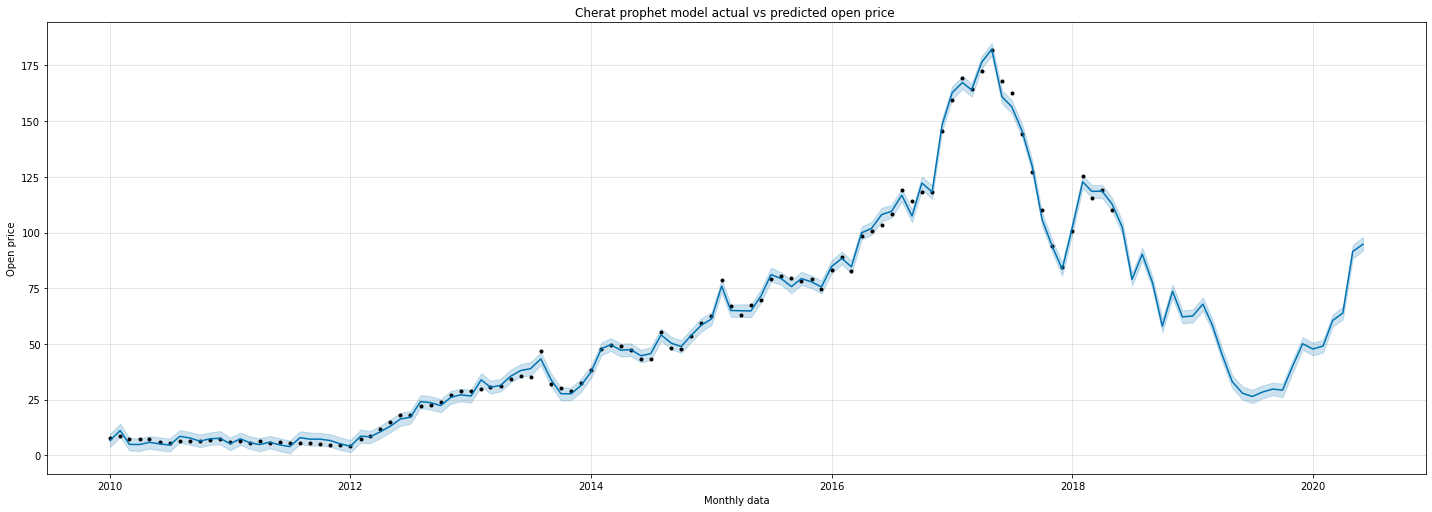

In [ ]:
######## Prophet Library with Exogenous variable ###########
m = Prophet()
m.add_seasonality(period=6, name='monthly', fourier_order = 1)
m.add_regressor('Price')
m.add_regressor('High')
m.add_regressor('Low')
m.add_regressor('Vol')
m.add_regressor('Net_Margin')
#m.add_regressor('ROE')
m.add_regressor('Quick_Ratio')
m.add_regressor('Current_Ratio')
m.add_regressor('Assets_Equity')
m.add_regressor('Debt_Equity')
#m.add_regressor('A_RTurnover')
m.add_regressor('AvgA_RDays')
m.add_regressor('InvTurnover')
m.add_regressor('EBITDATotAssetsTTM')
m.add_regressor('ROATotAssets')
m.add_regressor('HistMktCap')
m.add_regressor('HistEV')
m.add_regressor('GDPExports')
#m.add_regressor('Inflationgdp')
m.add_regressor('moneysupply')
m.add_regressor('treasures_bill')
m.add_regressor('DollarRate_Open')
m.fit(train)
future = m.make_future_dataframe(periods=25,freq='MS')
future['Price'] = prophetdf['Price']
future['High'] = prophetdf['High']
future['Low'] = prophetdf['Low']
future['Vol'] = prophetdf['Vol']
future['Net_Margin'] = prophetdf['Net_Margin']
#future['ROE'] = prophetdf['ROE']
future['Quick_Ratio'] = prophetdf['Quick_Ratio']
future['Current_Ratio'] = prophetdf['Current_Ratio']
future['Assets_Equity'] = prophetdf['Assets_Equity']
future['Debt_Equity'] = prophetdf['Debt_Equity']
#future['A_RTurnover'] = prophetdf['A_RTurnover']
future['AvgA_RDays'] = prophetdf['AvgA_RDays']
future['InvTurnover'] = prophetdf['InvTurnover']
future['EBITDATotAssetsTTM'] = prophetdf['EBITDATotAssetsTTM']
future['ROATotAssets'] = prophetdf['ROATotAssets']
future['HistMktCap'] = prophetdf['HistMktCap']
future['HistEV'] = prophetdf['HistEV']
future['GDPExports'] = prophetdf['GDPExports']
#future['Inflationgdp'] = prophetdf['Inflationgdp']
future['moneysupply'] = prophetdf['moneysupply']
future['treasures_bill'] = prophetdf['treasures_bill']
future['DollarRate_Open'] = prophetdf['DollarRate_Open']
future.Price.fillna(0, inplace=True)
future.High.fillna(0, inplace=True)
future.Low.fillna(0, inplace=True)
future.Vol.fillna(0, inplace=True)
future.Net_Margin.fillna(0, inplace=True)

future.Quick_Ratio.fillna(0, inplace=True)
future.Current_Ratio.fillna(0, inplace=True)
future.Assets_Equity.fillna(0, inplace=True)
future.Debt_Equity.fillna(0, inplace=True)
#future.A_RTurnover.fillna(0, inplace=True)
future.AvgA_RDays.fillna(0, inplace=True)
future.EBITDATotAssetsTTM.fillna(0, inplace=True)
future.InvTurnover.fillna(0, inplace=True)
future.ROATotAssets.fillna(0, inplace=True)
future.HistMktCap.fillna(0, inplace=True)
future.HistEV.fillna(0, inplace=True)
future.GDPExports.fillna(0, inplace=True)
#future.Inflationgdp.fillna(0, inplace=True)
future.moneysupply.fillna(0, inplace=True)
future.treasures_bill.fillna(0, inplace=True)
future.DollarRate_Open.fillna(0, inplace=True)
#future.ROE.fillna(0, inplace=True)
forecastt = m.predict(future)
forecastt.head(70)
m.plot(forecastt, figsize=(20, 7));
plt.xlabel("Monthly data")
plt.ylabel("Open price")
plt.title("Cherat prophet model actual vs predicted open price ")

Text(0.5, 1.0, 'Cherat prophet model actual vs predicted open price ')

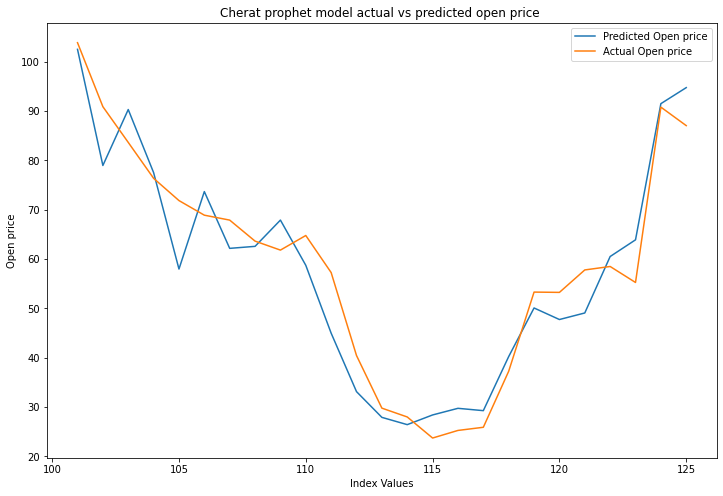

In [ ]:
forecastt['yhat'].iloc[101:].plot(figsize=(12,8),legend=True,label='Predicted Open price')
test['y'].plot(figsize=(12,8),legend=True, label='Actual Open price')
plt.xlabel("Index Values")
plt.ylabel("Open price")
plt.title("Cherat prophet model actual vs predicted open price ")

In [ ]:
predictions = forecastt.iloc[-25:]['yhat']

In [ ]:
def mse_rmse(test_variable,prediction_variable):
    a = rmse(test_variable,prediction_variable)
    b = mse(test_variable,prediction_variable)
    print('rmse =', a)
    print('mse =', b)

In [ ]:
mse_rmse(test['y'],predictions)

rmse = 6.45082929142646
mse = 41.61319854712561


In [ ]:
# Normalisation

In [ ]:
prophetdf= prophetlibrary(df_normalise)

In [ ]:
#train = df_normalise.drop(['ROE','moneysupply'],axis='columns') 
train = prophetdf.iloc[:101]
#train.shape
#test = df_normalise.drop(['ROE','moneysupply'],axis='columns') 
test = prophetdf.iloc[101:]

In [ ]:
######## Prophet Library with Exogenous variable ###########


def prophet_train(x,y,z):   # seasonality period = x , fourier order = y , future periods = z 
  m = Prophet()

  m.add_seasonality(period=x, name='monthly', fourier_order = y)

  m.add_regressor('Price')
  m.add_regressor('High')
  m.add_regressor('Low')

  m.add_regressor('Vol')
  m.add_regressor('Net_Margin')
  m.add_regressor('ROE')
  m.add_regressor('Quick_Ratio')
  m.add_regressor('Current_Ratio')
  m.add_regressor('Assets_Equity')
  m.add_regressor('Debt_Equity')
  m.add_regressor('A_RTurnover')
  m.add_regressor('AvgA_RDays')
  m.add_regressor('InvTurnover')
  m.add_regressor('EBITDATotAssetsTTM')
  m.add_regressor('ROATotAssets')
  m.add_regressor('HistMktCap')
  m.add_regressor('HistEV')
  m.add_regressor('GDPExports')
  m.add_regressor('Inflationgdp')
  m.add_regressor('moneysupply')
  m.add_regressor('treasures_bill')
  m.add_regressor('DollarRate_Open')

  m.fit(train)
  future = m.make_future_dataframe(periods=25,freq='MS')

  future['Price'] = prophetdf['Price']
  future['High'] = prophetdf['High']
  future['Low'] = prophetdf['Low']
  future['Vol'] = prophetdf['Vol']
  future['Net_Margin'] = prophetdf['Net_Margin']
  future['ROE'] = prophetdf['ROE']
  future['Quick_Ratio'] = prophetdf['Quick_Ratio']
  future['Current_Ratio'] = prophetdf['Current_Ratio']
  future['Assets_Equity'] = prophetdf['Assets_Equity']
  future['Debt_Equity'] = prophetdf['Debt_Equity']
  future['A_RTurnover'] = prophetdf['A_RTurnover']
  future['AvgA_RDays'] = prophetdf['AvgA_RDays']
  future['InvTurnover'] = prophetdf['InvTurnover']
  future['EBITDATotAssetsTTM'] = prophetdf['EBITDATotAssetsTTM']
  future['ROATotAssets'] = prophetdf['ROATotAssets']
  future['HistMktCap'] = prophetdf['HistMktCap']
  future['HistEV'] = prophetdf['HistEV']
  future['GDPExports'] = prophetdf['GDPExports']
  future['Inflationgdp'] = prophetdf['Inflationgdp']
  future['moneysupply'] = prophetdf['moneysupply']
  future['treasures_bill'] = prophetdf['treasures_bill']
  future['DollarRate_Open'] = prophetdf['DollarRate_Open']

  future.Price.fillna(0, inplace=True)
  future.High.fillna(0, inplace=True)
  future.Low.fillna(0, inplace=True)
  future.Vol.fillna(0, inplace=True)
  future.Net_Margin.fillna(0, inplace=True)
  future.ROE.fillna(0, inplace=True)
  future.Quick_Ratio.fillna(0, inplace=True)
  future.Current_Ratio.fillna(0, inplace=True)
  future.Assets_Equity.fillna(0, inplace=True)
  future.Debt_Equity.fillna(0, inplace=True)
  future.A_RTurnover.fillna(0, inplace=True)
  future.AvgA_RDays.fillna(0, inplace=True)
  future.EBITDATotAssetsTTM.fillna(0, inplace=True)
  future.InvTurnover.fillna(0, inplace=True)
  future.ROATotAssets.fillna(0, inplace=True)
  future.HistMktCap.fillna(0, inplace=True)
  future.HistEV.fillna(0, inplace=True)
  future.GDPExports.fillna(0, inplace=True)
  future.Inflationgdp.fillna(0, inplace=True)
  future.moneysupply.fillna(0, inplace=True)
  future.treasures_bill.fillna(0, inplace=True)
  future.DollarRate_Open.fillna(0, inplace=True)
  forecastt = m.predict(future)
  predictions = forecastt['yhat'].iloc[101:]
  mse = mse_rmse(test['y'],predictions)

In [ ]:
parameters = []
for x in range(3,30):
  for y in range(1,7):
    print("the results of period {} , forier transformation {} and future prediction 25 are".format(x,y,21))
    prophet_train(x,y,21)
    

the results of period 3 , forier transformation 1 and future prediction 25 are


INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1489941367107879
mse = 0.022199252774192955
the results of period 3 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1494955244545167
mse = 0.022348911831931
the results of period 3 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.14943559791812938
mse = 0.02233099792514883
the results of period 3 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.15148034351123033
mse = 0.022946294470280338
the results of period 3 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.14894877893440572
mse = 0.022185738746050468
the results of period 3 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.14951867700955027
mse = 0.022355834774686213
the results of period 4 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.15944907887785417
mse = 0.02542400875499616
the results of period 4 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.15902433338458286
mse = 0.02528873860841095
the results of period 4 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.16020417175869744
mse = 0.025665376648890233
the results of period 4 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.15688358752089504
mse = 0.024612460033426337
the results of period 4 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.15710667326493138
mse = 0.024682506784373906
the results of period 4 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.15856073535682513
mse = 0.025141506796897136
the results of period 5 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.3732369887739313
mse = 0.1393058497890317
the results of period 5 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.40322938574476436
mse = 0.16259393752809997
the results of period 5 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.4388459145290491
mse = 0.19258573669883744
the results of period 5 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.4092730495678678
mse = 0.1675044291025824
the results of period 5 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.41582993642162824
mse = 0.17291453602441537
the results of period 5 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.4078372472138755
mse = 0.1663312202149918
the results of period 6 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.14711343787761394
mse = 0.021642363604170572
the results of period 6 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.13976402242896274
mse = 0.019533981965523597
the results of period 6 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.17097385970931728
mse = 0.029232060703901303
the results of period 6 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.15647023469729207
mse = 0.02448293434622566
the results of period 6 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.18424690772222288
mse = 0.033946923005201315
the results of period 6 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1725959234466921
mse = 0.029789352790416404
the results of period 7 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.16637693730267633
mse = 0.027681285266218693
the results of period 7 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1560676508875555
mse = 0.0243571116535599
the results of period 7 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.18193928969856113
mse = 0.033101905136016956
the results of period 7 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1776067259343445
mse = 0.03154414909711736
the results of period 7 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.18654520108201741
mse = 0.034799112046730314
the results of period 7 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.18387333879719983
mse = 0.03380940472042983
the results of period 8 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.18733908776024036
mse = 0.03509593380283904
the results of period 8 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1792473612264372
mse = 0.03212961650664086
the results of period 8 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.19431895519238873
mse = 0.03775985634706158
the results of period 8 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.22409146734861782
mse = 0.05021698573845664
the results of period 8 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.2180009513327908
mse = 0.04752441478200182
the results of period 8 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.2058311127978599
mse = 0.04236644699560533
the results of period 9 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1647038690454919
mse = 0.027127364478554537
the results of period 9 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1629991517076863
mse = 0.026568723457425333
the results of period 9 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1561079023050585
mse = 0.02436967716208569
the results of period 9 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.14765447212043908
mse = 0.021801843137165523
the results of period 9 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.14876270315137016
mse = 0.022130341848902675
the results of period 9 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1493575613909155
mse = 0.02230768114464109
the results of period 10 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.21581274810237838
mse = 0.04657514224350062
the results of period 10 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.7538464253772951
mse = 0.5682844330541257
the results of period 10 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.7800348706333242
mse = 0.6084543994039469
the results of period 10 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.7861483951167412
mse = 0.6180292991446278
the results of period 10 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.7433791587163362
mse = 0.5526125736138078
the results of period 10 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.7310893398092912
mse = 0.5344916227827854
the results of period 11 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.15909377872587877
mse = 0.025310830429278872
the results of period 11 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.15531907732897599
mse = 0.02412401578232442
the results of period 11 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.15811001568520244
mse = 0.024998777059974966
the results of period 11 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.17037233650192968
mse = 0.02902673304512676
the results of period 11 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.19156575835646963
mse = 0.03669743977468932
the results of period 11 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.21267201197601515
mse = 0.04522938467792634
the results of period 12 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1551637076545005
mse = 0.02407577617309129
the results of period 12 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.14642049265192425
mse = 0.021438960668432205
the results of period 12 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1536461477056953
mse = 0.023607138704800336
the results of period 12 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.14597523403311835
mse = 0.021308768951023672
the results of period 12 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.14943939724058508
mse = 0.02233213344762939
the results of period 12 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.15705761388137296
mse = 0.024667094078110435
the results of period 13 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1548139297764632
mse = 0.023967352852831674
the results of period 13 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1516885704275849
mse = 0.023009422398364388
the results of period 13 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.19073948935260931
mse = 0.03638155279849416
the results of period 13 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1786169203990847
mse = 0.03190400425285296
the results of period 13 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.19418171380882376
mse = 0.037706537977731935
the results of period 13 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.19296916908754064
mse = 0.037237100218335845
the results of period 14 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.19277046622676777
mse = 0.037160452649285414
the results of period 14 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.2332270260216431
mse = 0.054394845666900185
the results of period 14 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.2603956186833291
mse = 0.06780587822947375
the results of period 14 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.22808353454315697
mse = 0.052022098729699484
the results of period 14 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.3140843946155866
mse = 0.09864900694103955
the results of period 14 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.36714816316174287
mse = 0.13479777371304177
the results of period 15 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.40447606297977773
mse = 0.16360088552362112
the results of period 15 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.6120410784746788
mse = 0.3745942817404479
the results of period 15 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.2076129079696424
mse = 0.04310311955561121
the results of period 15 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.2178551586203008
mse = 0.04746087013747642
the results of period 15 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.2107995443404694
mse = 0.04443644789414952
the results of period 15 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.20623300185308924
mse = 0.04253205105333631
the results of period 16 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.16775466543864037
mse = 0.028141627776430162
the results of period 16 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.193749733609611
mse = 0.03753895927379523
the results of period 16 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.2126365946001931
mse = 0.04521432136316687
the results of period 16 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.20793013379247394
mse = 0.04323494053895611
the results of period 16 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.22729592454515096
mse = 0.051663437314834956
the results of period 16 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.29604699853914257
mse = 0.08764382534403507
the results of period 17 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.159781433821279
mse = 0.02553010659398376
the results of period 17 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.158291375017646
mse = 0.025056159404977043
the results of period 17 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1617552308486066
mse = 0.026164754706886013
the results of period 17 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1708498403920184
mse = 0.029189667961978163
the results of period 17 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.14601663689155164
mse = 0.021320858249119244
the results of period 17 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.15216291665603018
mse = 0.02315355320526999
the results of period 18 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1598437690844698
mse = 0.0255500305151293
the results of period 18 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.17039702922939304
mse = 0.02903514757020263
the results of period 18 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.15721775976354008
mse = 0.0247174239850662
the results of period 18 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.16635392553582254
mse = 0.027673628541177994
the results of period 18 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.15569490709490919
mse = 0.024240904095292403
the results of period 18 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.14965853010721455
mse = 0.022397675633852046
the results of period 19 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1548695651492492
mse = 0.023984582209517543
the results of period 19 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.18244942975996983
mse = 0.03328779441973816
the results of period 19 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.20908632160032728
mse = 0.04371708988035549
the results of period 19 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.2101830852107972
mse = 0.04417692930872924
the results of period 19 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.2081569488659346
mse = 0.04332931536117532
the results of period 19 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.20974357155084797
mse = 0.04399236580690569
the results of period 20 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.16776193234470477
mse = 0.0281440659440293
the results of period 20 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.2757143339051512
mse = 0.0760183939207612
the results of period 20 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.289775765844809
mse = 0.08396999447094558
the results of period 20 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.8609151455671435
mse = 0.741174887866896
the results of period 20 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.8748931248412203
mse = 0.7654379798944351
the results of period 20 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.950266857272944
mse = 0.9030071000313978
the results of period 21 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1523464927585938
mse = 0.023209453855844272
the results of period 21 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.15405318002598523
mse = 0.02373238227611861
the results of period 21 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.16621018451593972
mse = 0.027625825436822724
the results of period 21 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.17119276490063645
mse = 0.029306962754324588
the results of period 21 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1743878866797354
mse = 0.03041113502062423
the results of period 21 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.18665833092565393
mse = 0.03484133250395093
the results of period 22 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.15789384979534324
mse = 0.024930467803194408
the results of period 22 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1564065383616143
mse = 0.02446300524226313
the results of period 22 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.17769373831620347
mse = 0.0315750646367874
the results of period 22 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.15700615219740002
mse = 0.024650931827833136
the results of period 22 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.19549286249821005
mse = 0.03821745928774406
the results of period 22 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.20593421917964455
mse = 0.04240890262912988
the results of period 23 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.14885981526376613
mse = 0.022159244600362577
the results of period 23 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.14522173470575922
mse = 0.02108935223094991
the results of period 23 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.17112974062789219
mse = 0.029285388127369652
the results of period 23 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.16439797819932023
mse = 0.02702669523602417
the results of period 23 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1849232973457319
mse = 0.03419662590121798
the results of period 23 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.20463357639905286
mse = 0.041874900589867
the results of period 24 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1621906692422645
mse = 0.026305813189253645
the results of period 24 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.16070667302435837
mse = 0.02582663475455804
the results of period 24 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.17402352016306294
mse = 0.030284185569943976
the results of period 24 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.16495816529583113
mse = 0.027211196297766742
the results of period 24 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.16615338891303202
mse = 0.027606948647285273
the results of period 24 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.16802679897751635
mse = 0.028233005174630694
the results of period 25 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.16074177573023266
mse = 0.02583791846490841
the results of period 25 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.1592873814110406
mse = 0.02537246987678632
the results of period 25 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.15790836046806558
mse = 0.024935050305712535
the results of period 25 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.2032393476209919
mse = 0.04130623242140639
the results of period 25 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.4542837693930574
mse = 0.20637374313396456
the results of period 25 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.41225932873020693
mse = 0.16995775412508082
the results of period 26 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.19772962255693124
mse = 0.0390970036365065
the results of period 26 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.23338884763999998
mse = 0.054470354202727125
the results of period 26 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.18415215624465253
mse = 0.03391201664955492
the results of period 26 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.18156619862192577
mse = 0.0329662844820166
the results of period 26 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.16268120493240848
mse = 0.026465174438260283
the results of period 26 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.16861055592243143
mse = 0.028429519568471378
the results of period 27 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.15871173427730484
mse = 0.025189414597309823
the results of period 27 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.2045511916115814
mse = 0.041841189989717885
the results of period 27 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.23364951739263315
mse = 0.05459209697781038
the results of period 27 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.2186235757179372
mse = 0.04779626785969662
the results of period 27 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.22350403111728
mse = 0.04995405192567407
the results of period 27 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.20877777223174393
mse = 0.043588158178049945
the results of period 28 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.25933204007703714
mse = 0.06725310701051801
the results of period 28 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.4047306838159117
mse = 0.16380692642209552
the results of period 28 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.3924314448246784
mse = 0.1540024388871846
the results of period 28 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.3895505270364746
mse = 0.1517496131143951
the results of period 28 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.45988678917155956
mse = 0.21149585885452646
the results of period 28 , forier transformation 6 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.43087338419914584
mse = 0.18565187321122475
the results of period 29 , forier transformation 1 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.3005574749447225
mse = 0.09033479574514751
the results of period 29 , forier transformation 2 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.33829017250855614
mse = 0.11444024081586868
the results of period 29 , forier transformation 3 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.31556198390643747
mse = 0.09957936568696671
the results of period 29 , forier transformation 4 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.36795416399023156
mse = 0.1353902667977502
the results of period 29 , forier transformation 5 and future prediction 25 are


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


rmse = 0.36956708062559984
mse = 0.13657982708212862
the results of period 29 , forier transformation 6 and future prediction 25 are
rmse = 0.3844368648426705
mse = 0.14779170305006167


In [ ]:
######## Prophet Library with Exogenous variable ###########
m = Prophet()
m.add_seasonality(period=6, name='monthly', fourier_order = 2)
m.add_regressor('Price')
m.add_regressor('High')
m.add_regressor('Low')
m.add_regressor('Vol')
#m.add_regressor('Net_Margin')
m.add_regressor('ROE')
m.add_regressor('Quick_Ratio')
m.add_regressor('Current_Ratio')
#m.add_regressor('Assets_Equity')
m.add_regressor('Debt_Equity')
m.add_regressor('A_RTurnover')
m.add_regressor('AvgA_RDays')
m.add_regressor('InvTurnover')
m.add_regressor('EBITDATotAssetsTTM')
m.add_regressor('ROATotAssets')
m.add_regressor('HistMktCap')
m.add_regressor('HistEV')
m.add_regressor('GDPExports')
m.add_regressor('Inflationgdp')
m.add_regressor('moneysupply')
m.add_regressor('treasures_bill')
#m.add_regressor('DollarRate_Open')
m.fit(train)
future = m.make_future_dataframe(periods=25,freq='MS')
future['Price'] = prophetdf['Price']
future['High'] = prophetdf['High']
future['Low'] = prophetdf['Low']
future['Vol'] = prophetdf['Vol']
#future['Net_Margin'] = prophetdf['Net_Margin']
future['ROE'] = prophetdf['ROE']
future['Quick_Ratio'] = prophetdf['Quick_Ratio']
future['Current_Ratio'] = prophetdf['Current_Ratio']
#future['Assets_Equity'] = prophetdf['Assets_Equity']
future['Debt_Equity'] = prophetdf['Debt_Equity']
future['A_RTurnover'] = prophetdf['A_RTurnover']
future['AvgA_RDays'] = prophetdf['AvgA_RDays']
future['InvTurnover'] = prophetdf['InvTurnover']
future['EBITDATotAssetsTTM'] = prophetdf['EBITDATotAssetsTTM']
future['ROATotAssets'] = prophetdf['ROATotAssets']
future['HistMktCap'] = prophetdf['HistMktCap']
future['HistEV'] = prophetdf['HistEV']
future['GDPExports'] = prophetdf['GDPExports']
future['Inflationgdp'] = prophetdf['Inflationgdp']
future['moneysupply'] = prophetdf['moneysupply']
future['treasures_bill'] = prophetdf['treasures_bill']
#future['DollarRate_Open'] = prophetdf['DollarRate_Open']






future.Quick_Ratio.fillna(0, inplace=True)
future.Current_Ratio.fillna(0, inplace=True)
#future.Assets_Equity.fillna(0, inplace=True)
future.Debt_Equity.fillna(0, inplace=True)
future.A_RTurnover.fillna(0, inplace=True)
future.AvgA_RDays.fillna(0, inplace=True)
future.EBITDATotAssetsTTM.fillna(0, inplace=True)
future.InvTurnover.fillna(0, inplace=True)
future.ROATotAssets.fillna(0, inplace=True)
future.HistMktCap.fillna(0, inplace=True)
future.HistEV.fillna(0, inplace=True)
future.GDPExports.fillna(0, inplace=True)
future.Inflationgdp.fillna(0, inplace=True)
future.moneysupply.fillna(0, inplace=True)
future.treasures_bill.fillna(0, inplace=True)
#future.DollarRate_Open.fillna(0, inplace=True)
future.ROE.fillna(0, inplace=True)
future.Price.fillna(0, inplace=True)
future.High.fillna(0, inplace=True)
future.Low.fillna(0, inplace=True)
future.Vol.fillna(0, inplace=True)
#future.Net_Margin.fillna(0, inplace=True)
forecastt = m.predict(future)
forecastt.head(70)
m.plot(forecastt, figsize=(20, 7));
plt.xlabel("Monthly data")
plt.ylabel("Open price")
plt.title("Cherat prophet model actual vs predicted open price ")

In [ ]:
forecastt['yhat'].iloc[101:].plot(figsize=(12,8),legend=True,label='Predicted Open price')
test['y'].plot(figsize=(12,8),legend=True, label='Actual Open price')
plt.xlabel("Index Values")
plt.ylabel("Open price")
plt.title("Cherat prophet model actual vs predicted open price ")

In [ ]:
predictions = forecastt.iloc[-25:]['yhat']

In [ ]:
mse_rmse(test['y'],predictions)

rmse = 0.14132994782342773
mse = 0.019974154151772807


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Text(0.5, 1.0, 'Cherat prophet model actual vs predicted open price ')

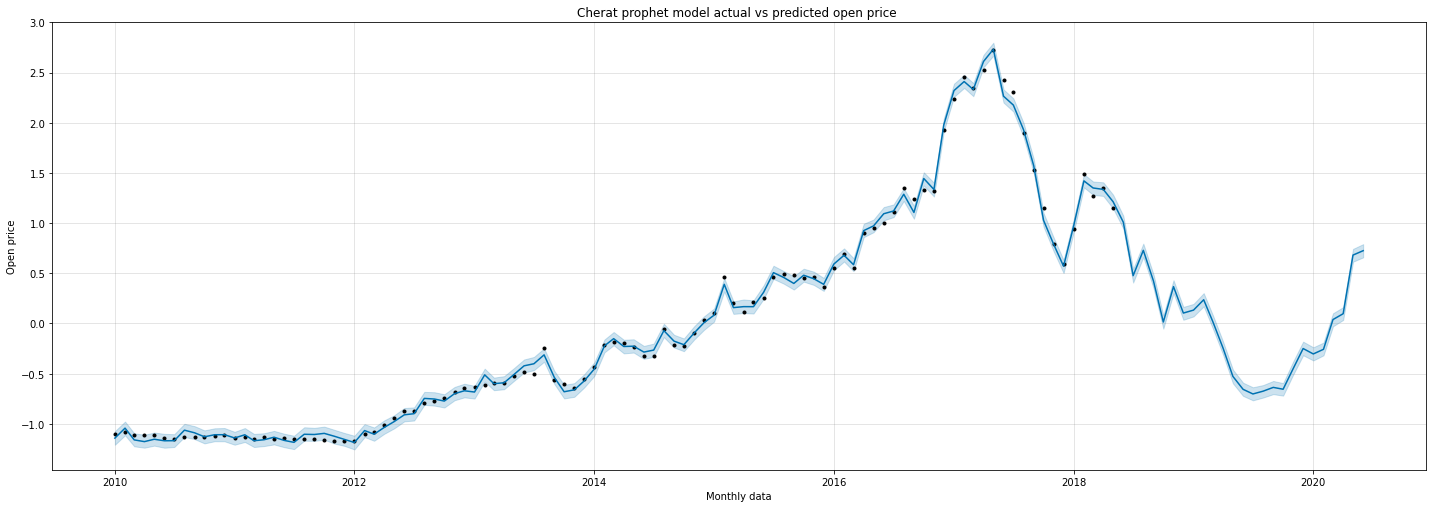

In [ ]:
######## Prophet Library with Exogenous variable ###########
m = Prophet()
m.add_seasonality(period=6, name='monthly', fourier_order = 2)
m.add_regressor('Price')
m.add_regressor('High')
m.add_regressor('Low')
m.add_regressor('Vol')
m.add_regressor('Net_Margin')
#m.add_regressor('ROE')
m.add_regressor('Quick_Ratio')
m.add_regressor('Current_Ratio')
m.add_regressor('Assets_Equity')
m.add_regressor('Debt_Equity')
#m.add_regressor('A_RTurnover')
m.add_regressor('AvgA_RDays')
m.add_regressor('InvTurnover')
m.add_regressor('EBITDATotAssetsTTM')
m.add_regressor('ROATotAssets')
m.add_regressor('HistMktCap')
m.add_regressor('HistEV')
m.add_regressor('GDPExports')
#m.add_regressor('Inflationgdp')
m.add_regressor('moneysupply')
m.add_regressor('treasures_bill')
m.add_regressor('DollarRate_Open')
m.fit(train)
future = m.make_future_dataframe(periods=25,freq='MS')
future['Price'] = prophetdf['Price']
future['High'] = prophetdf['High']
future['Low'] = prophetdf['Low']
future['Vol'] = prophetdf['Vol']
future['Net_Margin'] = prophetdf['Net_Margin']
#future['ROE'] = prophetdf['ROE']
future['Quick_Ratio'] = prophetdf['Quick_Ratio']
future['Current_Ratio'] = prophetdf['Current_Ratio']
future['Assets_Equity'] = prophetdf['Assets_Equity']
future['Debt_Equity'] = prophetdf['Debt_Equity']
#future['A_RTurnover'] = prophetdf['A_RTurnover']
future['AvgA_RDays'] = prophetdf['AvgA_RDays']
future['InvTurnover'] = prophetdf['InvTurnover']
future['EBITDATotAssetsTTM'] = prophetdf['EBITDATotAssetsTTM']
future['ROATotAssets'] = prophetdf['ROATotAssets']
future['HistMktCap'] = prophetdf['HistMktCap']
future['HistEV'] = prophetdf['HistEV']
future['GDPExports'] = prophetdf['GDPExports']
#future['Inflationgdp'] = prophetdf['Inflationgdp']
future['moneysupply'] = prophetdf['moneysupply']
future['treasures_bill'] = prophetdf['treasures_bill']
future['DollarRate_Open'] = prophetdf['DollarRate_Open']
future.Price.fillna(0, inplace=True)
future.High.fillna(0, inplace=True)
future.Low.fillna(0, inplace=True)
future.Vol.fillna(0, inplace=True)
future.Net_Margin.fillna(0, inplace=True)

future.Quick_Ratio.fillna(0, inplace=True)
future.Current_Ratio.fillna(0, inplace=True)
future.Assets_Equity.fillna(0, inplace=True)
future.Debt_Equity.fillna(0, inplace=True)
#future.A_RTurnover.fillna(0, inplace=True)
future.AvgA_RDays.fillna(0, inplace=True)
future.EBITDATotAssetsTTM.fillna(0, inplace=True)
future.InvTurnover.fillna(0, inplace=True)
future.ROATotAssets.fillna(0, inplace=True)
future.HistMktCap.fillna(0, inplace=True)
future.HistEV.fillna(0, inplace=True)
future.GDPExports.fillna(0, inplace=True)
#future.Inflationgdp.fillna(0, inplace=True)
future.moneysupply.fillna(0, inplace=True)
future.treasures_bill.fillna(0, inplace=True)
future.DollarRate_Open.fillna(0, inplace=True)
#future.ROE.fillna(0, inplace=True)
forecastt = m.predict(future)
forecastt.head(70)
m.plot(forecastt, figsize=(20, 7));
plt.xlabel("Monthly data")
plt.ylabel("Open price")
plt.title("Cherat prophet model actual vs predicted open price ")